# Import libraries

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,f1_score,ConfusionMatrixDisplay
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC

# Reading data & preliminary statistics

In [2]:
data_raw = pd.read_csv("data-prob-2-Telco-Cust-Churn.csv")
data_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## No. of rows and columns

In [3]:
print("No of Rows: {0}".format(data_raw.shape[0]))
print("No of Columns: {0}".format(data_raw.shape[1]))


No of Rows: 7043
No of Columns: 21


## Data description

In [4]:
data_raw.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Preprocessing

In [6]:
data_raw["TotalCharges"].replace({" ":np.nan},inplace=True)
total_charges_mean = data_raw["TotalCharges"].dropna()
total_charges_mean = total_charges_mean.astype(float)
total_charges_mean = total_charges_mean.mean()
data_raw["TotalCharges"].fillna(total_charges_mean, inplace=True)
data_raw["TotalCharges"] = data_raw["TotalCharges"].astype(float)


In [7]:
data_raw.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## Value counts

In [8]:
for col in data_raw.columns.to_list():
    print("\n------- {0} -------\n".format(col))
    print(data_raw[col].value_counts())


------- customerID -------

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

------- gender -------

Male      3555
Female    3488
Name: gender, dtype: int64

------- SeniorCitizen -------

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

------- Partner -------

No     3641
Yes    3402
Name: Partner, dtype: int64

------- Dependents -------

No     4933
Yes    2110
Name: Dependents, dtype: int64

------- tenure -------

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

------- PhoneService -------

Yes    6361
No      682
Name: PhoneService, dtype: int64

------- MultipleLines -------

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

------- Internet

## Null Records %

In [9]:
for col in data_raw.columns.to_list():
    print("\n{0} -------> {1}".format(col, round(data_raw[col].isna().sum()/data_raw.shape[0],2)))



customerID -------> 0.0

gender -------> 0.0

SeniorCitizen -------> 0.0

Partner -------> 0.0

Dependents -------> 0.0

tenure -------> 0.0

PhoneService -------> 0.0

MultipleLines -------> 0.0

InternetService -------> 0.0

OnlineSecurity -------> 0.0

OnlineBackup -------> 0.0

DeviceProtection -------> 0.0

TechSupport -------> 0.0

StreamingTV -------> 0.0

StreamingMovies -------> 0.0

Contract -------> 0.0

PaperlessBilling -------> 0.0

PaymentMethod -------> 0.0

MonthlyCharges -------> 0.0

TotalCharges -------> 0.0

Churn -------> 0.0


# EDA & Visualization

## Processing

In [10]:
data_processed = data_raw.copy()
data_processed.drop("customerID", axis=1, inplace=True)
data_processed["SeniorCitizen"].replace({0:"No",1: "Yes"}, inplace=True)


## Visualization

In [11]:
def histogram_visualization(col):
    fig = px.histogram(data_processed, x=col,color="Churn",
                   template="plotly_dark",
                   title="{0} vs Churn".format(col))
    fig.update_layout(title_x = 0.5,)
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

## Outliers

In [12]:
fig = px.box(data_processed, y=["tenure","MonthlyCharges","TotalCharges"],
             labels={
                     "variable": "Columns with numerical values",
                     "value": "Values",
                 },
             template="plotly_dark",
             title="Outliers Visulaization")
fig.update_layout(title_x = 0.5,)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [13]:
fig = px.histogram(data_processed, x="MonthlyCharges",color="Churn",
                   template="plotly_dark",
                   title="Monthly Charges Distribution vs Churn")
fig.update_layout(title_x = 0.5,)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [14]:
fig = px.histogram(data_processed, x="TotalCharges",color="Churn",
                   template="plotly_dark",
                   title="Monthly Charges Distribution vs Churn")
fig.update_layout(title_x = 0.5,)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [15]:
col_list = ["gender","SeniorCitizen","Partner","Dependents","PhoneService",
            "MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection",
            "TechSupport","StreamingTV","StreamingMovies"]
for col in col_list:
    histogram_visualization(col)

### Insight 
The customer is more likley to churn if he/she is not a senior citizen, has no partner, uses a phone service and fiber, but not uses Online Security and backup

# Model Building

## Train-Test Split

In [16]:
X = data_processed.drop("Churn",axis=1)
y = data_processed["Churn"]

y.replace({"Yes":1,"No":0},inplace=True)

X_enc = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_enc,y, test_size=0.1,random_state=111,stratify=y)

## Applying Models

In [17]:
def model_building(X, y, test, model, params = None, k = 3) :
    
    if params == None :
        model.fit(X, y)
        
        # return fitted model & train-test predictions
        return (model, model.predict(X), model.predict(test))
    
    else :
        model_cv = GridSearchCV(model, param_grid = params, cv = k)
        model_cv.fit(X, y)
        model = model_cv
        
        # return and extra object for all cross validation operations
        return (model_cv, model, model.predict(X), model.predict(test))
    
def model_evaluation(y_train, pred_train, y_test, pred_test,model) :
    
    print('''
            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TRAIN DATA |
            +--------------------------------------+''')
    print(classification_report(y_train, pred_train))
    # print(confusion_matrix(y_train, pred_train))
    print("Printing Confussion Matrix for Train Data")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, pred_train),
                                   display_labels=model.classes_)
    disp.plot()
    disp.ax_.set_title("Train Data {}".format(model))
    print("F1 Score: ",f1_score(y_train, pred_train,average="macro"))
    
    print('''
            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TEST DATA  |
            +--------------------------------------+''')
    print(classification_report(y_test, pred_test))
    # print(confusion_matrix(y_test, pred_test))
    print("Printing Confussion Matrix for Test Data")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_test),
                                   display_labels=model.classes_)
    disp.plot()
    disp.ax_.set_title(disp.ax_.set_title("Test Data {}".format(model)))
    print("F1 Score: ",f1_score(y_test, pred_test,average="macro"))


In [18]:
def plot_roc_curve(model,X_test,y_test):
    # Predict probabilities on the test set
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


***** Performing for GaussianNB() *****


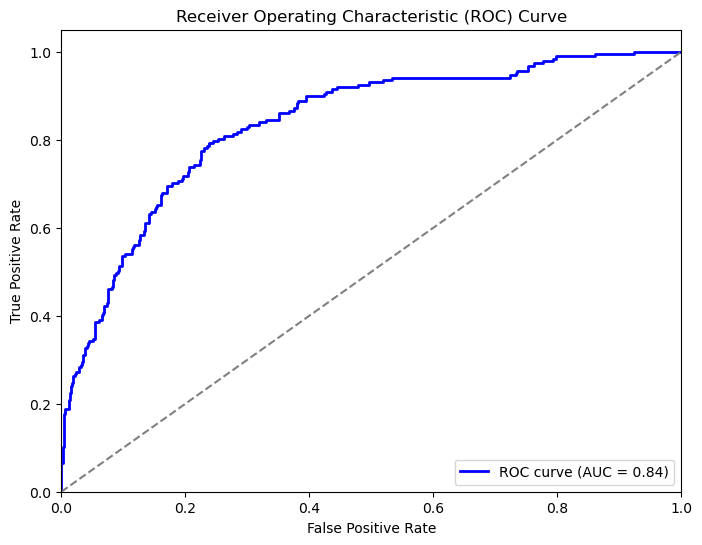


            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TRAIN DATA |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.93      0.59      0.72      4656
           1       0.43      0.87      0.58      1682

    accuracy                           0.66      6338
   macro avg       0.68      0.73      0.65      6338
weighted avg       0.80      0.66      0.68      6338

Printing Confussion Matrix for Train Data
F1 Score:  0.6484146240305255

            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TEST DATA  |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.94      0.59      0.72       518
           1       0.44      0.90      0.59       187

    accuracy                           0.67       705
   macro avg       0.69      0.74      0.66       705
weighted 

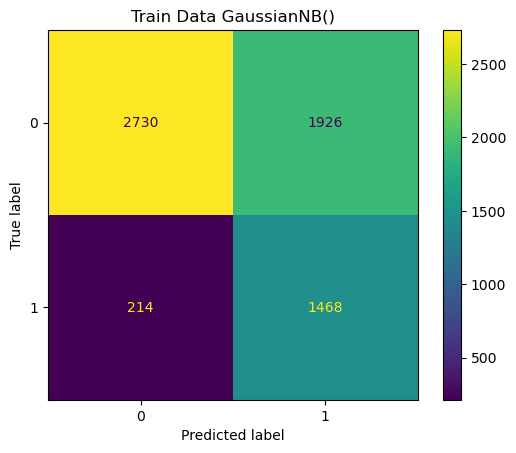

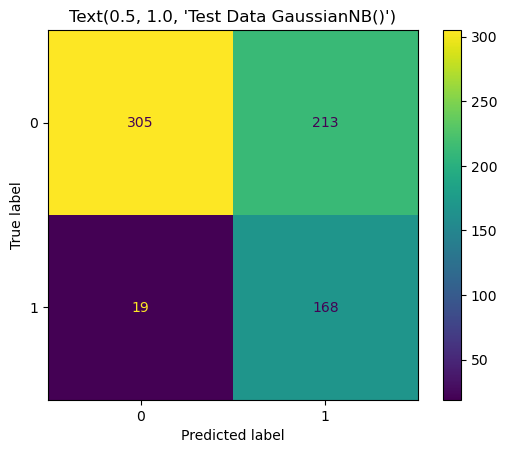

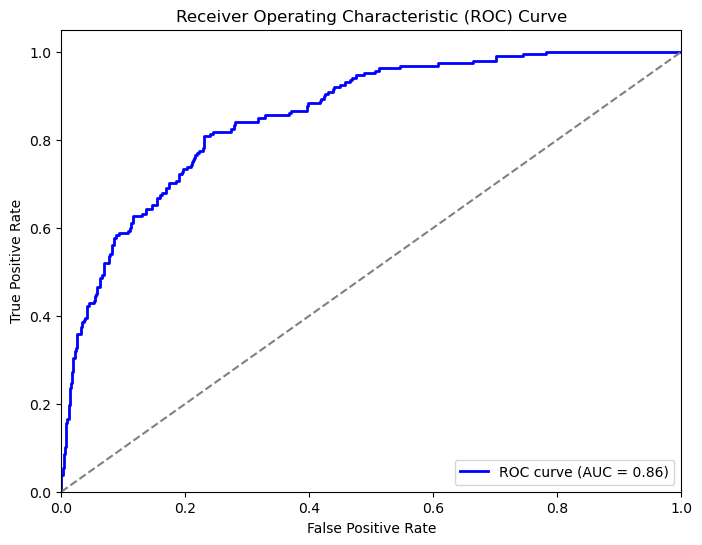


            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TRAIN DATA |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4656
           1       0.66      0.54      0.60      1682

    accuracy                           0.81      6338
   macro avg       0.75      0.72      0.73      6338
weighted avg       0.80      0.81      0.80      6338

Printing Confussion Matrix for Train Data
F1 Score:  0.7342021195610802

            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TEST DATA  |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.86      0.92      0.88       518
           1       0.71      0.57      0.63       187

    accuracy                           0.82       705
   macro avg       0.78      0.74      0.76       705
weighted 

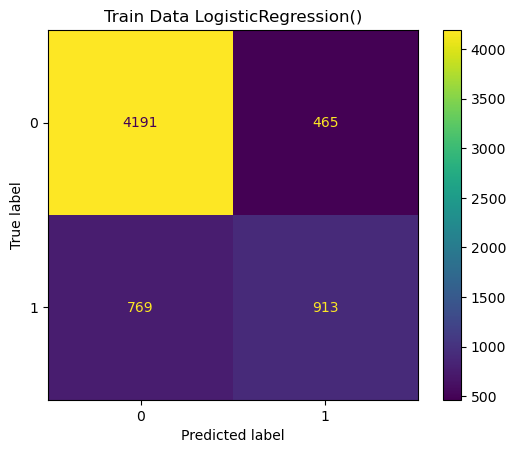

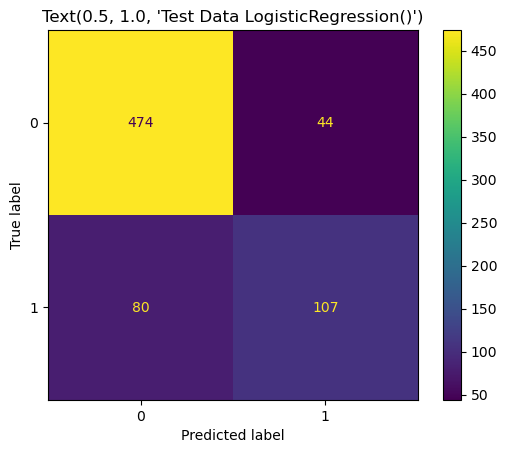

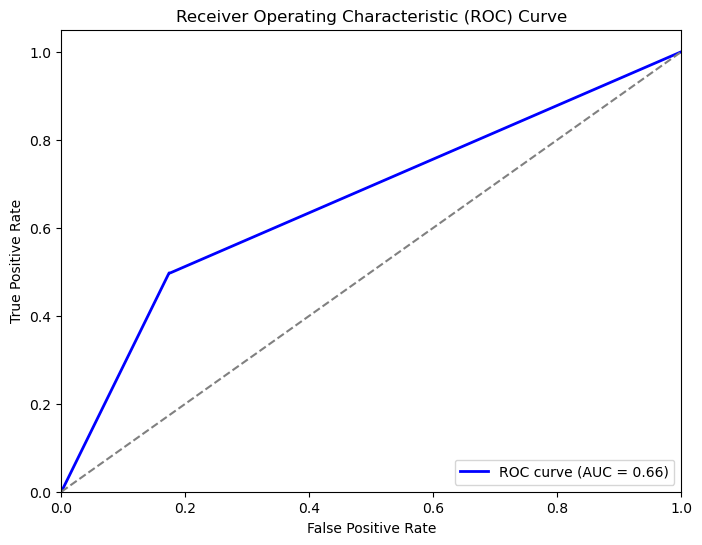


            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TRAIN DATA |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4656
           1       1.00      0.99      1.00      1682

    accuracy                           1.00      6338
   macro avg       1.00      1.00      1.00      6338
weighted avg       1.00      1.00      1.00      6338

Printing Confussion Matrix for Train Data
F1 Score:  0.9971609437599891

            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TEST DATA  |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       518
           1       0.51      0.49      0.50       187

    accuracy                           0.74       705
   macro avg       0.66      0.66      0.66       705
weighted 

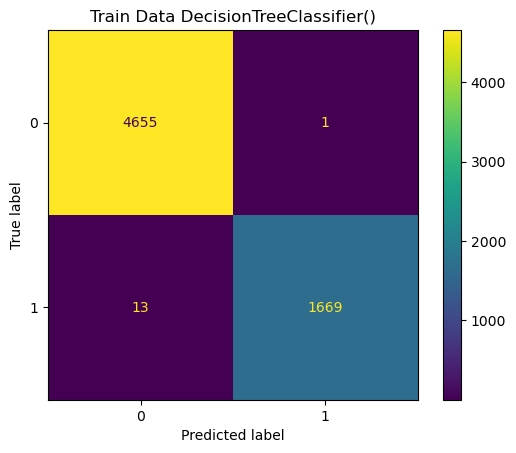

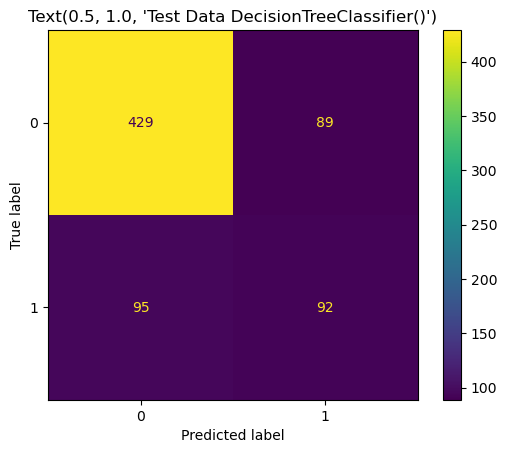

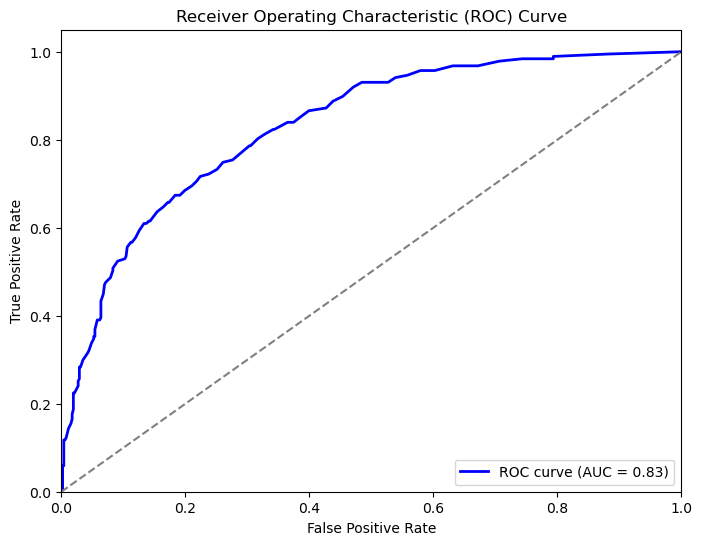


            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TRAIN DATA |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4656
           1       1.00      0.99      1.00      1682

    accuracy                           1.00      6338
   macro avg       1.00      1.00      1.00      6338
weighted avg       1.00      1.00      1.00      6338

Printing Confussion Matrix for Train Data
F1 Score:  0.9969622124730273

            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TEST DATA  |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       518
           1       0.69      0.51      0.58       187

    accuracy                           0.81       705
   macro avg       0.76      0.71      0.73       705
weighted 

d:\Softwares\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\Softwares\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\Softwares\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\Softwares\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

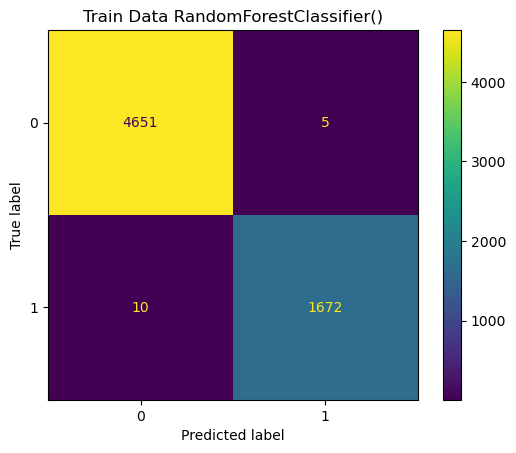

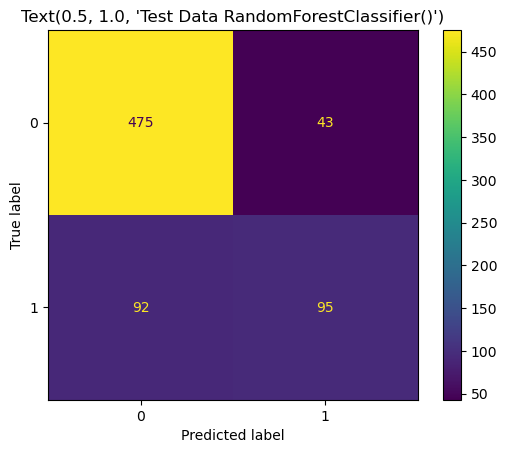

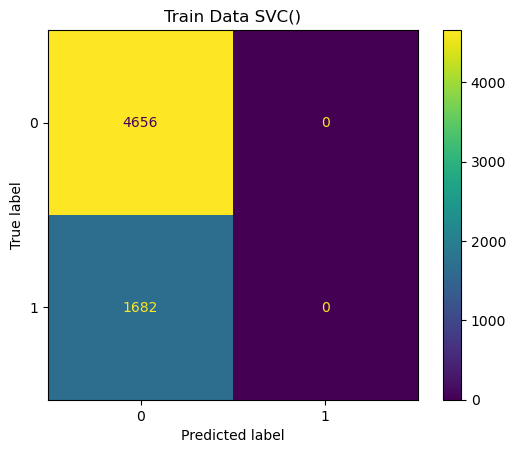

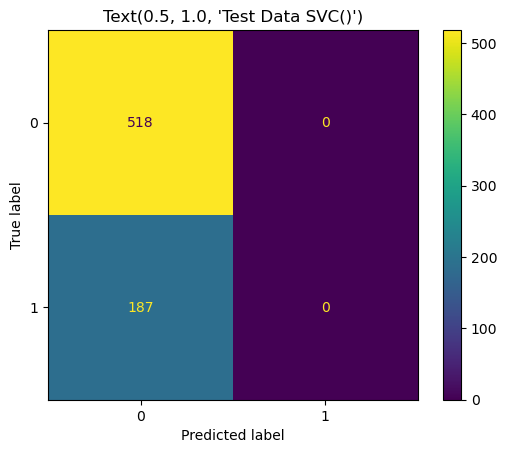

In [19]:
model_list = [GaussianNB(), LogisticRegression(), DecisionTreeClassifier(),RandomForestClassifier(),SVC()]
# model_list =[GaussianNB()]
for model in model_list:
    print("\n***** Performing for {0} *****".format(model))
    model, pred_train, pred_test = model_building(X_train, y_train,X_test,model,params = None)
    try:
        plot_roc_curve(model,X_test,y_test)
    except:
        print("Unable to create a model for {0}".format(model))
    model_evaluation(y_train, pred_train, y_test, pred_test,model)

## Hyper Parameter Tuning

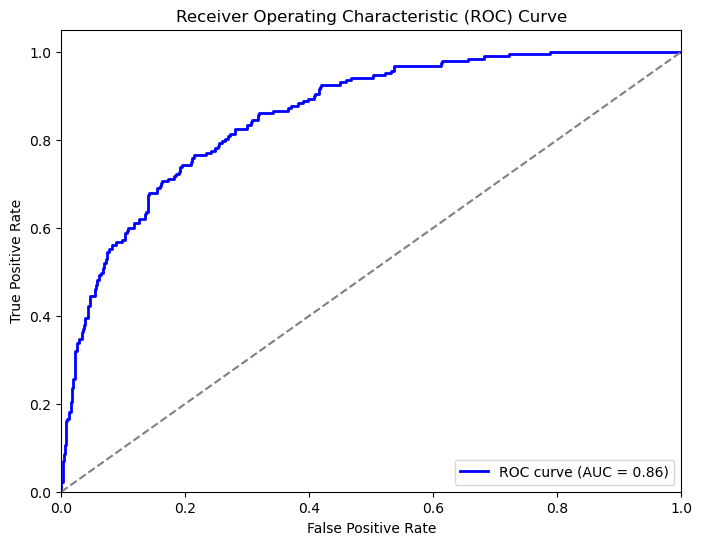

			 LogisticRegression 

{'penalty': 'l1', 'solver': 'liblinear'} 



            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TRAIN DATA |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4656
           1       0.66      0.55      0.60      1682

    accuracy                           0.80      6338
   macro avg       0.75      0.72      0.73      6338
weighted avg       0.80      0.80      0.80      6338

Printing Confussion Matrix for Train Data
F1 Score:  0.7348677009561364

            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TEST DATA  |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       518
           1       0.70      0.56      0.62       187

    accuracy                           0.82     

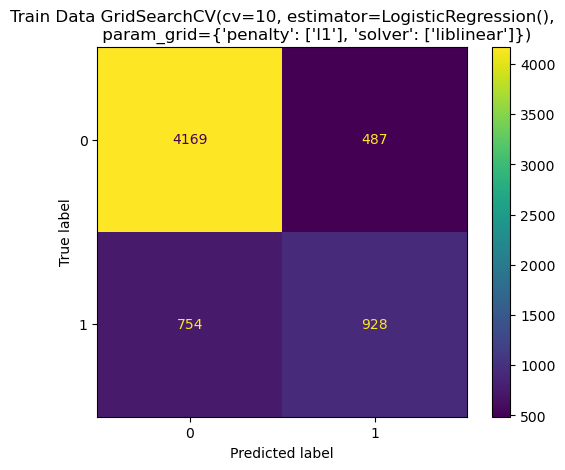

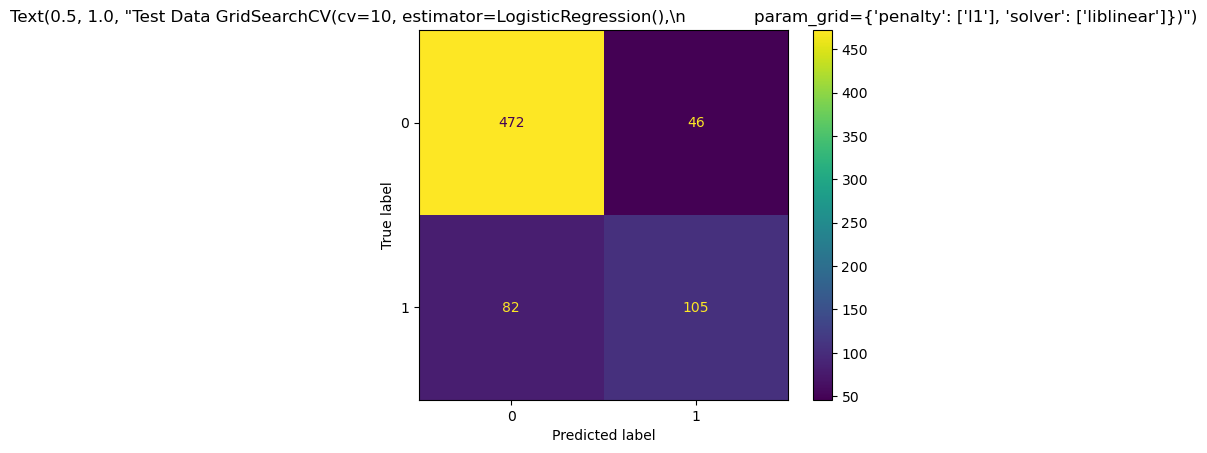

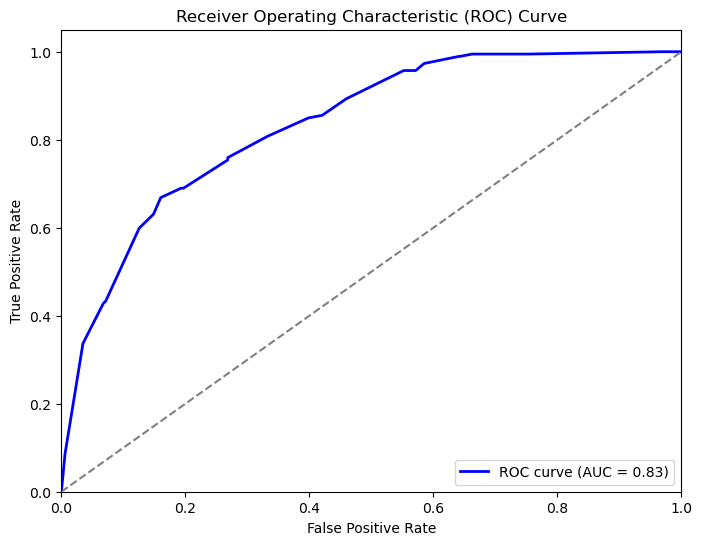

			 DecisionTreeClassifier 

{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10, 'splitter': 'best'} 



            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TRAIN DATA |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      4656
           1       0.68      0.45      0.54      1682

    accuracy                           0.80      6338
   macro avg       0.75      0.69      0.71      6338
weighted avg       0.79      0.80      0.78      6338

Printing Confussion Matrix for Train Data
F1 Score:  0.7063339197129762

            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TEST DATA  |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       518
           1       0.70      0.43  

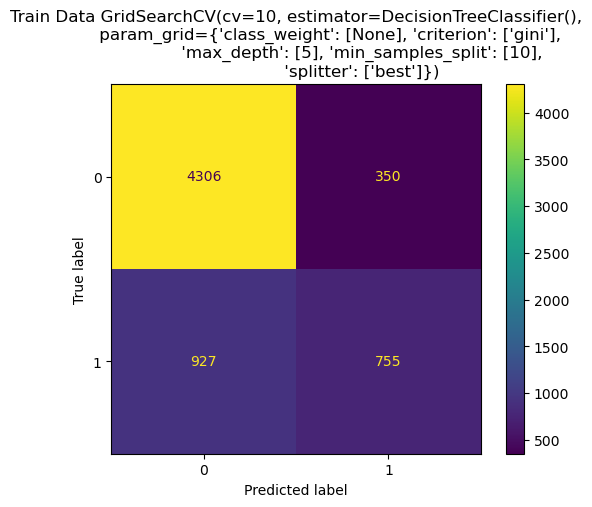

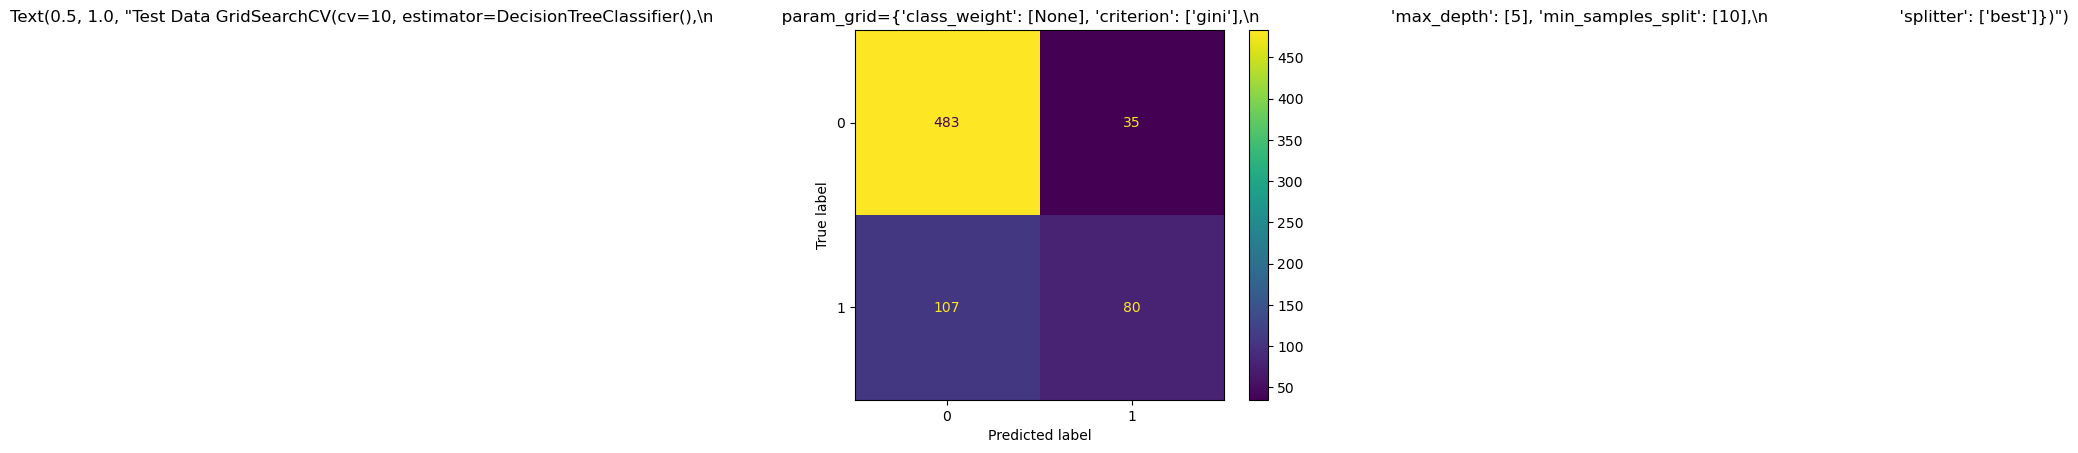

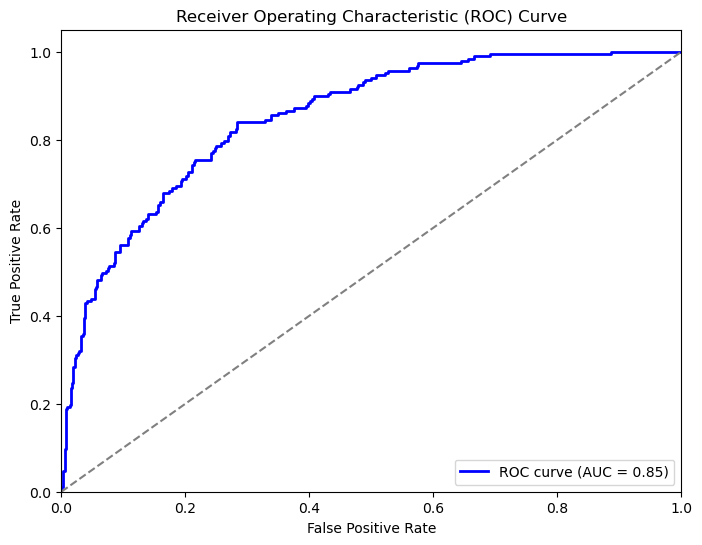

			 RandomForestClassifier 

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 4} 



            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TRAIN DATA |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4656
           1       0.79      0.62      0.69      1682

    accuracy                           0.85      6338
   macro avg       0.83      0.78      0.80      6338
weighted avg       0.85      0.85      0.85      6338

Printing Confussion Matrix for Train Data
F1 Score:  0.7984512721619288

            +--------------------------------------+
            | CLASSIFICATION REPORT FOR TEST DATA  |
            +--------------------------------------+
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       518
           1       0.69      0.54      0.61       187



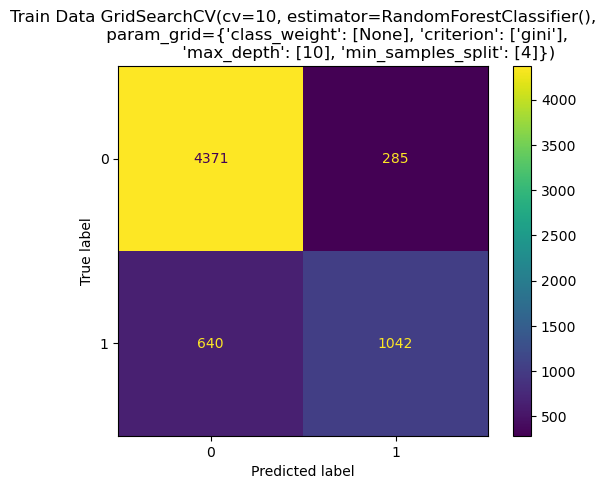

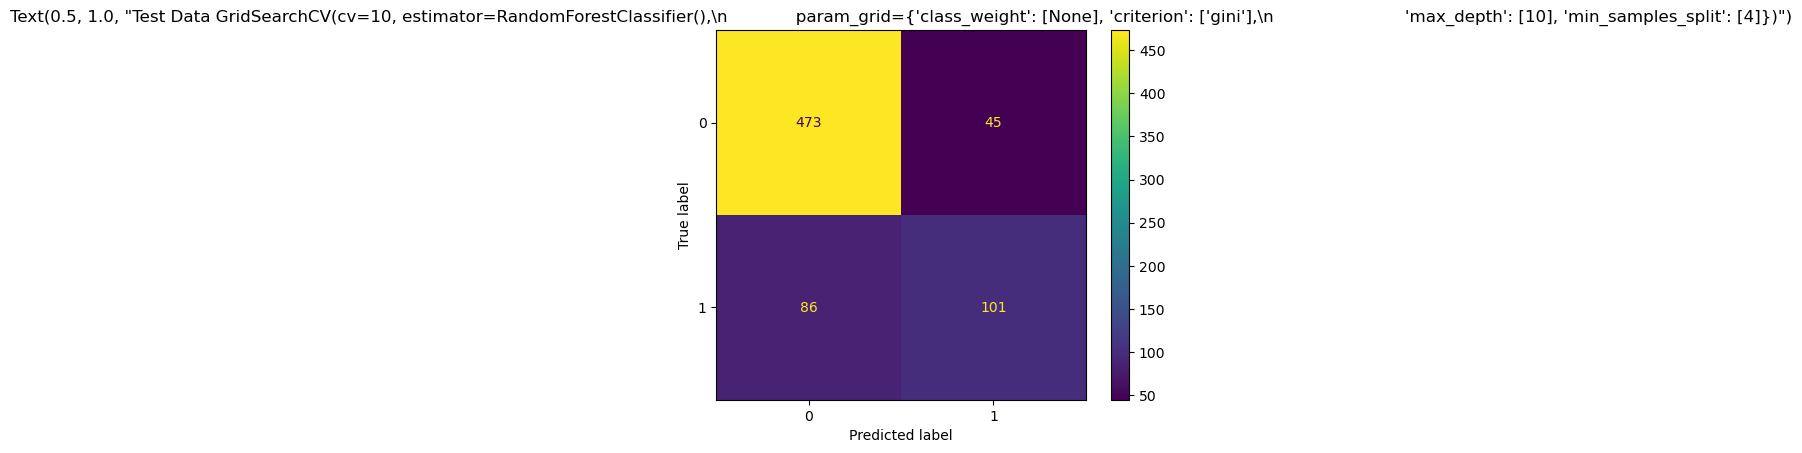

In [20]:
estimators = [
    # (LogisticRegression(), {"penalty": ["l1","l2","elasticnet"],
    #                        "solver":["liblinear","saga"]}),

    (LogisticRegression(), {"penalty": ["l1"],
                           "solver":["liblinear"]}),
                                                      
    
    # (DecisionTreeClassifier(), {'criterion' : ["entropy","gini"],
    #                                       "splitter": ["best","random"],
    #                                       "min_samples_split" : [2,4,6,10], 
    #                                       "max_depth" : [5, 10], 'class_weight' : ['balanced',None]}),
    
    (DecisionTreeClassifier(), {'criterion' : ["gini"],
                                          "splitter": ["best"],
                                          "min_samples_split" : [10], 
                                          "max_depth" : [5], 'class_weight' : [None]}),
    
    # (RandomForestClassifier(), {'criterion' : ["entropy","gini"],
    #                                       "min_samples_split" : [2,4,6,10], 
    #                                       "max_depth" : [5, 10], 'class_weight' : ['balanced',None]}),

    (RandomForestClassifier(), {'criterion' : ["gini"],
                                          "min_samples_split" : [4], 
                                          "max_depth" : [10], 'class_weight' : [None]})

    # (SVC(), {"kernel": ["linear"]})
                
                                          ]

for estimator, parameters in estimators :
    
    model_cv, model, pred_train, pred_test = model_building(X_train, y_train, X_test, 
                                                            estimator, parameters, 10)
    try:
        plot_roc_curve(model_cv,X_test,y_test)
    except:
        print("Unable to create a model for {0}".format(model))
    print('===================================================================\n\t\t\t',
          type(estimator).__name__,
          '\n===================================================================\n')
    
    print(model_cv.best_params_, '\n\n')
    
    model_evaluation(y_train, pred_train, y_test, pred_test,model_cv)

The Vanilla Logistic Regressio model gives good results with f1 score of 75% and 86% auc area

# Miscellaneous

## ROC Curve

## Vizualization code

## Label Encoding